# Wines Points prediction 

In [42]:
import numpy
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import dill
dump_file_name = 'score_pred.db'

Here we will try to predict the points a wine will get based on known characteristics (i.e. features, in the ML terminology). The mine point in this stage is to establish a simple, ideally super cost effective, basline.
In the real world there is a tradeoff between complexity and perforamnce, and the DS job, among others, is to present a tradeoff tables of what performance is achivalbel at what complexity level. 

to which models with increased complexity and resource demands will be compared. Complexity should then be translated into cost. For example:
 * Compute cost 
 * Maintenance cost
 * Serving costs (i.e. is new platform needed?) 
 

## Loading the data

In [44]:
import pandas as pd
import cufflinks as cf; cf.go_offline()

In [45]:
wine_reviews = pd.read_csv("data/winemag-data-130k-v2.csv")
wine_reviews.shape

(129971, 14)

In [41]:
wine_reviews.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [99]:
wine_reviews.sample(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
40872,40872,US,Baked cinnamon and cherry tart form a promisin...,Riviera,84,22.0,California,Sonoma Coast,Sonoma,Virginie Boone,@vboone,Pali 2013 Riviera Pinot Noir (Sonoma Coast),Pinot Noir,Pali
41119,41119,Italy,"This opens with aromas of raisin, scorched ear...",Terre di Monteforte,90,46.0,Veneto,Amarone della Valpolicella,NaN,Kerin O’Keefe,@kerinokeefe,Cantina di Monteforte 2011 Terre di Monteforte...,Red Blend,Cantina di Monteforte
26716,26716,US,"Aromas of plum, blue fruit, cocoa and herbs le...",NaN,88,17.0,Washington,Horse Heaven Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Six Prong 2014 Cabernet Sauvignon (Horse Heave...,Cabernet Sauvignon,Six Prong
68495,68495,US,"Lighter in color and density, this wine shows ...",NaN,86,18.0,California,Monterey,Central Coast,Matt Kettmann,@mattkettmann,Ranch 32 2012 Pinot Noir (Monterey),Pinot Noir,Ranch 32
127862,127862,Italy,"This wine opens with aromas of prune, plum, bl...",Colle Rotondella,87,18.0,Southern Italy,Campi Flegrei,NaN,Kerin O’Keefe,@kerinokeefe,Cantine Astroni 2012 Colle Rotondella Piediros...,Piedirosso,Cantine Astroni


In [5]:
wine_reviews = wine_reviews.drop(columns=['Unnamed: 0'])

In [6]:
wine_reviews = wine_reviews.drop_duplicates()
wine_reviews['desc_lower'] = wine_reviews['description'].apply(lambda x: x.lower())
wine_reviews.shape

(119988, 14)

## Points prediction

Points is descrete value target. There for we are talking about a prediction (Regression) problem (in contrary to classification problem). Prediction solutions can be measured in few metrics:

* MSE - [Mean score error](https://en.wikipedia.org/wiki/Mean_squared_error)
* R2 - [R Square](https://en.wikipedia.org/wiki/Coefficient_of_determination)
* MAE - [Mean absolut error](https://en.wikipedia.org/wiki/Mean_absolute_error)

Read more [here](https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b)

### Train and test set split

To properly report results, let's split to train and test datasets:

In [46]:
train_data = wine_reviews.sample(frac = 0.8)
test_data = wine_reviews[~wine_reviews.index.isin(train_data.index)]
assert(len(train_data) + len(test_data) == len(wine_reviews))

In [47]:
len(test_data), len(train_data)

(25994, 103977)

### Baselines

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [9]:
def calc_prediction_quality(df, pred_score_col, true_score_col):
    return pd.Series({'MSE': mean_squared_error(df[true_score_col], df[pred_score_col]),
                      'MAE': mean_absolute_error(df[true_score_col], df[pred_score_col]),
                      'R2': r2_score(df[true_score_col], df[pred_score_col])})

#### Baseline 1

The most basic baseline is simply the average points. The implementaion is as simple as:

In [106]:
test_data['basiline_1_predicted_points'] = train_data.points.mean()
b1_stats = calc_prediction_quality(test_data, 'basiline_1_predicted_points', 'points')
b1_stats

MSE    9.645944
MAE    2.548396
R2    -0.000102
dtype: float64

#### Basline 2

We can probably improve by predicting the average score based on the origin country:

In [107]:
avg_points_by_country = train_data.groupby('country').points.mean()
avg_points_by_country.head()

country
Argentina                 86.641389
Armenia                   87.500000
Australia                 88.493536
Austria                   90.136158
Bosnia and Herzegovina    88.000000
Name: points, dtype: float64

In [108]:
test_data['basiline_2_predicted_points'] = test_data.country.map(avg_points_by_country).fillna(train_data.points.mean())
b2_stats = calc_prediction_quality(test_data, 'basiline_2_predicted_points', 'points')
b2_stats

MSE    9.157956
MAE    2.476033
R2     0.050493
dtype: float64

### Baseline 3

Adding more breakdowns will increase our granularity but can result in overfitting. Yet:

In [109]:
avg_points_by_country_and_region = train_data.groupby(['country','province']).points.mean().rename('basiline_3_predicted_points')
avg_points_by_country_and_region.head()

country    province        
Argentina  Mendoza Province    86.755187
           Other               85.975728
Armenia    Armenia             87.500000
Australia  Australia Other     85.442105
           New South Wales     87.553846
Name: basiline_3_predicted_points, dtype: float64

In [110]:
test_data_with_baseline_3 = test_data.merge(avg_points_by_country_and_region, on = ['country','province'], how='left')
test_data_with_baseline_3.basiline_3_predicted_points = test_data_with_baseline_3.basiline_3_predicted_points.fillna(test_data_with_baseline_3.basiline_2_predicted_points).fillna(test_data.basiline_1_predicted_points)
test_data_with_baseline_3.shape, test_data.shape

((23998, 17), (23998, 16))

In [111]:
b3_stats = calc_prediction_quality(test_data_with_baseline_3, 'basiline_3_predicted_points', 'points')
b3_stats

MSE    8.598005
MAE    2.380009
R2     0.108550
dtype: float64

### Baselines summary

In [112]:
baseline_summary = pd.DataFrame([b1_stats, b2_stats, b3_stats], index=['baseline_1', 'baseline_2','baseline_3'])
baseline_summary

,MSE,MAE,R2
baseline_1,9.645944,2.548396,-0.000102
baseline_2,9.157956,2.476033,0.050493
baseline_3,8.598005,2.380009,0.108550


In [113]:
baseline_summary.to_csv('data/baselines_summary.csv', index=False)

## Training a Boosting trees regressor

In [113]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#### Preparing data - Lable encoding categorical features

In [114]:
categorical_features = ['country','province','region_1','region_2','taster_name','variety','winery']
numerical_features = ['price']

features = categorical_features + numerical_features

In [115]:
encoded_features = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features['price'] = wine_reviews.price.fillna(-1)
encoded_features['points'] = wine_reviews.points
encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points
0,22,332,424,6,9,691,11608,-1.0,87
1,32,108,738,6,16,451,12956,15.0,87
2,41,269,1218,17,15,437,13018,14.0,87
3,41,218,549,6,0,480,14390,13.0,87
4,41,269,1218,17,15,441,14621,65.0,87


#### Re-splitting to train and test

In [116]:
train_encoded_features = encoded_features[encoded_features.index.isin(train_data.index)]
test_encoded_features = encoded_features[encoded_features.index.isin(test_data.index)]
assert(len(train_encoded_features) + len(test_encoded_features) == len(wine_reviews))

#### Fitting a tree-regressor

In [118]:
from src.models import i_feel_lucky_xgboost_training

In [119]:
train_encoded_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95990 entries, 0 to 129969
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      95990 non-null  int64  
 1   province     95990 non-null  int64  
 2   region_1     95990 non-null  int64  
 3   region_2     95990 non-null  int64  
 4   taster_name  95990 non-null  int64  
 5   variety      95990 non-null  int64  
 6   winery       95990 non-null  int64  
 7   price        95990 non-null  float64
 8   points       95990 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 7.3 MB


In [120]:
xgb_clf, clf_name = i_feel_lucky_xgboost_training(train_encoded_features, test_encoded_features, features, 'points', name='xgb_clf_points_prediction')

Let's look at the function output - specifically the **xgb_clf_points_prediction** column:

In [121]:
test_encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points,xgb_clf_points_prediction
3,41,218,549,6,0,480,14390,13.0,87,87
5,38,263,758,6,12,591,14706,15.0,87,87
7,15,11,21,6,16,209,15395,24.0,87,88
9,15,11,21,6,16,437,8989,27.0,87,88
13,22,332,424,6,9,388,10819,-1.0,87,87


In [122]:
xgb_stats = calc_prediction_quality(test_encoded_features, 'xgb_clf_points_prediction','points')
xgb_stats

MSE    6.344070
MAE    1.911618
R2     0.342240
dtype: float64

In [123]:
from pandas import Series

all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb'])

In [124]:

from pandas import DataFrame


def save_results(previous: DataFrame, label: str, quality: Series):
    all_compared.to_csv('all_models_summary.csv', index=True)
    return previous.append(quality.to_frame(name=label).transpose())

def load_results():
    loaded = pd.read_csv('all_models_summary.csv', index_col=0)
    loaded.set_index('label', inplace=True)
    return loaded


all_compared

,MSE,MAE,R2
baseline_1,9.645944,2.548396,-0.000102
baseline_2,9.157956,2.476033,0.050493
baseline_3,8.598005,2.380009,0.108550
regression_by_xgb,6.344070,1.911618,0.342240


## Classical NLP approaches

### Using only the text from the "description" column

In [12]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to /Users/roi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/roi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/roi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [13]:
# Tokenize description using nltk - convert to lower and remove non-words
wines = wine_reviews.copy()
wines['description_lower'] = wines.description.apply(lambda d: d.lower())
wines['description_tokens'] = wines.description.apply(lambda d: [word.lower() for word in nltk.word_tokenize(d) if word.isalpha()])
wines.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,desc_lower,description_lower,description_tokens
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,"aromas include tropical fruit, broom, brimston...","aromas include tropical fruit, broom, brimston...","[aromas, include, tropical, fruit, broom, brim..."
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,"this is ripe and fruity, a wine that is smooth...","this is ripe and fruity, a wine that is smooth...","[this, is, ripe, and, fruity, a, wine, that, i..."
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,"tart and snappy, the flavors of lime flesh and...","tart and snappy, the flavors of lime flesh and...","[tart, and, snappy, the, flavors, of, lime, fl..."
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,"pineapple rind, lemon pith and orange blossom ...","pineapple rind, lemon pith and orange blossom ...","[pineapple, rind, lemon, pith, and, orange, bl..."
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,"much like the regular bottling from 2012, this...","much like the regular bottling from 2012, this...","[much, like, the, regular, bottling, from, thi..."


In [121]:
# split to train and test
train_data = wines[wines.index.isin(train_data.index)]
test_data = wines[wines.index.isin(test_data.index)]
assert(train_data.shape[0] + test_data.shape[0]  == wines.shape[0])

In [122]:
from pandas import Series

# create vocabulary
stopwords=nltk.corpus.stopwords.words("english")

def create_vocabulary(column: Series):
    return [word for description in column for word in description if word not in stopwords]

all_words = create_vocabulary(wines.description_tokens)
training_words = create_vocabulary(train_data.description_tokens)



In [123]:
# word counts for training data
words_df = pd.DataFrame(training_words, columns=['word']).word.value_counts().reset_index()
words_df.columns = ['word', 'word_count']
print(f'number of unique words: {words_df.shape[0]}')
words_df.head()

number of unique words: 27420


,word,word_count
0,wine,59106
1,flavors,46414
2,fruit,33273
3,aromas,28950
4,palate,27870


In [124]:
# calculate word importance - more frequent words across similar texts are considered less indicative
words_df['importance'] = len(words_df) / words_df.word_count / words_df.word_count.max()
words_df.sort_values('importance', ascending=True).head(20)

,word,word_count,importance
0,wine,59106,0.000008
1,flavors,46414,0.000010
2,fruit,33273,0.000014
3,aromas,28950,0.000016
4,palate,27870,0.000017
5,finish,25721,0.000018
6,acidity,25681,0.000018
7,tannins,22736,0.000020
8,drink,21928,0.000021
9,cherry,20204,0.000023


In [131]:
words_df.set_index('word').word_count.head(20).iplot(kind = 'bar', title = 'Word Frequency', yTitle = 'Count', xTitle = 'Word')

In [129]:
# try and reduce vocabulary size
d = []
for size in range(15):
    num_words = len(words_df[words_df.word_count > size])
    d.append([size, num_words, 1 - (num_words / len(words_df))])

vocab_size = pd.DataFrame(data=d, columns=['occ_gt', 'word_count', 'reduction'])

vocab_size.reduction.iplot(
    kind = 'line',
    title = 'reduction of vocab size when high passing different frequencies',
    yTitle = 'reduction',
    xTitle = 'occurrences gt'
)


In [133]:
print('we choose to keep only words that occur at least 5 times')

we choose to keep only words that occur at least 5 times


In [128]:
reduced_vocab = words_df[words_df.word_count > 4].word
print(len(reduced_vocab))
print(reduced_vocab[:5])

10397
0       wine
1    flavors
2      fruit
3     aromas
4     palate
Name: word, dtype: object


In [16]:
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer


# generalize for different vocabulary sizes

def predict_score_for_vocabulary(train: DataFrame, test: DataFrame, vocab: Series) -> Series:
    count_vect = CountVectorizer(vocabulary = vocab, tokenizer=nltk.word_tokenize)
    train_bow_counts = count_vect.fit_transform(train.description_lower)
    test_bow_counts = count_vect.fit_transform(test.description_lower)

    from sklearn.linear_model import RidgeCV

    alphas = (0.1, 1, 5, 10, 100, 1000)
    ridge_clf = RidgeCV(alphas=alphas, cv=10)
    ridge_clf.fit(train_bow_counts, y = train.points)

    results = test.copy()
    results['predicted'] = ridge_clf.predict(test_bow_counts)

    return calc_prediction_quality(results, 'predicted', 'points')



In [137]:
vocab_highpass_values = [5 ,4, 3, 2, 1]

for value in vocab_highpass_values:
    result = predict_score_for_vocabulary(
        train=train_data,
        test=test_data,
        vocab=words_df[words_df.word_count > value].word)
    all_compared = all_compared.append(result.to_frame(name=f'bow_ridge_gt_{value}').transpose())
    all_compared.to_csv('all_models_summary.csv', index=True)
    print(f'Results for highpass {value}:\n {result}')



/var/folders/37/gt5sm58d5s37rhym90b7k6f00000gn/T/ipykernel_31603/723500265.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Results for highpass 5:
 MSE    3.112649
MAE    1.385728
R2     0.677277
dtype: float64


/var/folders/37/gt5sm58d5s37rhym90b7k6f00000gn/T/ipykernel_31603/723500265.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Results for highpass 4:
 MSE    3.107394
MAE    1.384678
R2     0.677822
dtype: float64


/var/folders/37/gt5sm58d5s37rhym90b7k6f00000gn/T/ipykernel_31603/723500265.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Results for highpass 3:
 MSE    3.105675
MAE    1.383974
R2     0.678000
dtype: float64


/var/folders/37/gt5sm58d5s37rhym90b7k6f00000gn/T/ipykernel_31603/723500265.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Results for highpass 2:
 MSE    3.103572
MAE    1.383460
R2     0.678218
dtype: float64
Results for highpass 1:
 MSE    3.098569
MAE    1.382541
R2     0.678737
dtype: float64


/var/folders/37/gt5sm58d5s37rhym90b7k6f00000gn/T/ipykernel_31603/723500265.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [138]:
all_compared

,MSE,MAE,R2
baseline_1,9.645944,2.548396,-0.000102
baseline_2,9.157956,2.476033,0.050493
baseline_3,8.598005,2.380009,0.108550
regression_by_xgb,6.344070,1.911618,0.342240
bow_ridge_gt_5,3.112649,1.385728,0.677277
bow_ridge_gt_4,3.107394,1.384678,0.677822
bow_ridge_gt_3,3.105675,1.383974,0.678000
bow_ridge_gt_2,3.103572,1.383460,0.678218
bow_ridge_gt_1,3.098569,1.382541,0.678737


### Using both the text and other features

In [130]:
# get encoded train test split
train_encoded = encoded_features[encoded_features.index.isin(train_data.index)].iloc[:, 0:8]
test_encoded = encoded_features[encoded_features.index.isin(test_data.index)].iloc[:, 0:8]
# assert(train_encoded.shape[0] + test_encoded.shape[0] == encoded_features.shape[0])


In [132]:
# generate sparse matrices for encoded features - train and test - and concat with bag of words
# we will use the vocabulary frequency high pass value from previous iteration
# we choose 5 as using larger vocabularies yielded negligibly better results

reduced_vocab = words_df[words_df.word_count > 5].word

count_vect = CountVectorizer(vocabulary = reduced_vocab, tokenizer=nltk.word_tokenize)
train_bow_counts = count_vect.fit_transform(train_data.description_lower)
test_bow_counts = count_vect.fit_transform(test_data.description_lower)
assert(train_bow_counts.shape[0] + test_bow_counts.shape[0]  == wines.shape[0])

from scipy.sparse import coo_matrix, hstack

encoded_train = coo_matrix(train_encoded)
encoded_test = coo_matrix(test_encoded)
train_all_features = hstack((encoded_train, train_bow_counts))
test_all_features = hstack((encoded_test, test_bow_counts))
# assert(train_all_features.shape[0] + test_all_features.shape[0]  == encoded_features.shape[0])


In [142]:
from sklearn.linear_model import RidgeCV

# create new classifier
all_features_clf = RidgeCV(alphas=[1, 5, 10, 12 ,15], cv=10)
all_features_clf.fit(train_all_features, y = train_data.points)

RidgeCV(alphas=[1, 5, 10, 12, 15], cv=10)

In [143]:
all_features_results = test_data.copy()
all_features_results['predicted'] = all_features_clf.predict(test_all_features)

all_features_ridge = calc_prediction_quality(all_features_results, 'predicted','points')
all_compared = all_compared.append(all_features_ridge.to_frame(name='all_features_ridge').transpose())
all_compared.to_csv('all_models_summary.csv', index=True)

all_compared

/var/folders/37/gt5sm58d5s37rhym90b7k6f00000gn/T/ipykernel_31603/2187539876.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,MSE,MAE,R2
baseline_1,9.645944,2.548396,-0.000102
baseline_2,9.157956,2.476033,0.050493
baseline_3,8.598005,2.380009,0.108550
regression_by_xgb,6.344070,1.911618,0.342240
bow_ridge_gt_5,3.112649,1.385728,0.677277
bow_ridge_gt_4,3.107394,1.384678,0.677822
bow_ridge_gt_3,3.105675,1.383974,0.678000
bow_ridge_gt_2,3.103572,1.383460,0.678218
bow_ridge_gt_1,3.098569,1.382541,0.678737
all_features_ridge,3.723752,1.517671,0.613917


In [48]:
all_compared.to_csv('all_models_summary.csv', index=True)

## Deep Learning approaches

### Fully connected network on the text only

#### Tokenization

In [18]:
all_compared = pd.read_csv('all_models_summary.csv', index_col=0)
all_compared

,MSE,MAE,R2
baseline_1,9.645944,2.548396,-0.000102
baseline_2,9.157956,2.476033,0.050493
baseline_3,8.598005,2.380009,0.108550
regression_by_xgb,6.344070,1.911618,0.342240
bow_ridge_gt_5,3.112649,1.385728,0.677277
bow_ridge_gt_4,3.107394,1.384678,0.677822
bow_ridge_gt_3,3.105675,1.383974,0.678000
bow_ridge_gt_2,3.103572,1.383460,0.678218
bow_ridge_gt_1,3.098569,1.382541,0.678737
all_features_ridge,3.723752,1.517671,0.613917


In [48]:
import tensorflow as tf

In [49]:

from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


What is a good size for the vocabulary? 

In [50]:
wine_reviews.description.apply(lambda x: len(x.split(' '))).quantile([0.95, 0.99])

0.95    60.0
0.99    71.0
Name: description, dtype: float64

In [51]:
vocab_size = 32000
sequence_length = 60

# Use the text vectorization layer to normalize, split, and map strings to integers. Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    #standardize=lambda text: tf.strings.lower(text), # You can use your own normalization function here
    standardize='lower_and_strip_punctuation', # Or you can use a pre-made normalization function
    max_tokens=vocab_size,    
    split='whitespace',
    output_mode='int',
    name = 'Text_processing',
    output_sequence_length=sequence_length)

In [52]:
vectorize_layer.adapt(train_data['description'].to_numpy())

2022-06-30 23:30:12.307021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [149]:
sample_description = train_data['description'].sample().iloc[0]
print(sample_description)
vectorize_layer(sample_description)

A very fruity nose teases with the scent of ripe, yellow mirabelle plums. The palate is equally sprightly and full of primary fresh fruit, but here it is greengage and white currant rather than mirabelle. Wonderfully light-footed. Drink soon.


<tf.Tensor: shape=(60,), dtype=int64, numpy=
array([   4,   67,   73,   40, 4793,    6,    3, 1111,    5,   27,  184,
       1962,  476,    3,   18,    8, 1133, 1690,    2,   69,    5, 1131,
         39,   16,   23,  276,   12,    8, 7239,    2,   55,  126,  331,
        162, 1962,  949, 1963,   25,  438,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0])>

In [150]:
for token in vectorize_layer(sample_description).numpy()[:20]:
    print(f"{token} ---> ",vectorize_layer.get_vocabulary()[token])

4 --->  a
67 --->  very
73 --->  fruity
40 --->  nose
4793 --->  teases
6 --->  with
3 --->  the
1111 --->  scent
5 --->  of
27 --->  ripe
184 --->  yellow
1962 --->  mirabelle
476 --->  plums
3 --->  the
18 --->  palate
8 --->  is
1133 --->  equally
1690 --->  sprightly
2 --->  and
69 --->  full


#### Modeling

In [53]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [58]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 hidden_layer (Dense)        (None, 164)               2788      
                                                                 
 dropout (Dropout)           (None, 164)               0         
                                                                 
 output_layer (Dense)        (None, 1)                 1

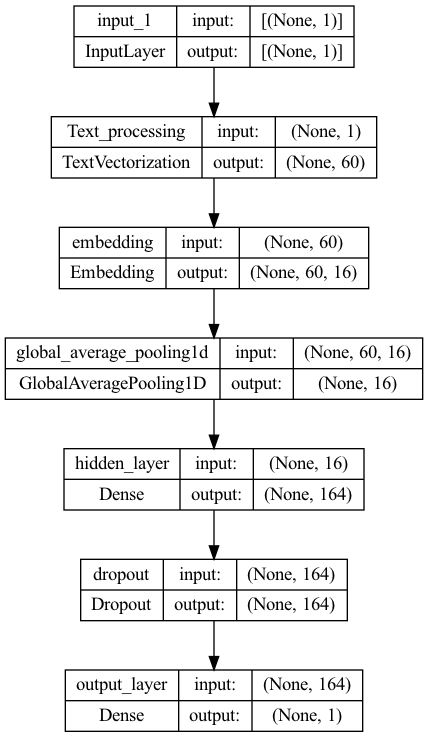

In [152]:
tf.keras.utils.plot_model(model, show_dtype=False, show_shapes=True, show_layer_names=True)

In [153]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

In [154]:
%%time
text_col, target_col = 'desc_lower', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20


2022-06-30 20:27:46.439389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - ETA: 0s - loss: 21.8487 - mean_squared_error: 1357.0977 - mean_absolute_error: 21.8487

2022-06-30 20:27:57.026921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 13s 17ms/step - loss: 21.8487 - mean_squared_error: 1357.0977 - mean_absolute_error: 21.8487 - val_loss: 2.4908 - val_mean_squared_error: 9.5861 - val_mean_absolute_error: 2.4908
Epoch 2/20
750/750 [==============================] - 10s 13ms/step - loss: 3.1053 - mean_squared_error: 15.1411 - mean_absolute_error: 3.1053 - val_loss: 1.7270 - val_mean_squared_error: 4.7754 - val_mean_absolute_error: 1.7270
Epoch 3/20
750/750 [==============================] - 10s 13ms/step - loss: 2.3954 - mean_squared_error: 9.3228 - mean_absolute_error: 2.3954 - val_loss: 1.6509 - val_mean_squared_error: 4.3774 - val_mean_absolute_error: 1.6509
Epoch 4/20
750/750 [==============================] - 10s 13ms/step - loss: 2.0038 - mean_squared_error: 6.7381 - mean_absolute_error: 2.0038 - val_loss: 1.6596 - val_mean_squared_error: 4.3864 - val_mean_absolute_error: 1.6596
Epoch 5/20
750/750 [==============================] - 10s 13ms/step - loss: 1.7960 - mean_squ

### Simple NN Prediction & Evaluation

In [155]:
test_data['dnn_prediction'] = model.predict(test_data['desc_lower'])

 63/750 [=>............................] - ETA: 1s

2022-06-30 20:29:07.997117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 2s 2ms/step


In [162]:
dnn_result = calc_prediction_quality(test_data, 'dnn_prediction', target_col)
dnn_result

MSE    4.377417
MAE    1.650926
R2     0.546145
dtype: float64

In [166]:

all_compared = all_compared.append(dnn_result.to_frame(name='dnn').transpose())
all_compared.to_csv('all_models_summary.csv', index=True)
all_compared

/var/folders/37/gt5sm58d5s37rhym90b7k6f00000gn/T/ipykernel_31603/524954956.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,MSE,MAE,R2
baseline_1,9.645944,2.548396,-0.000102
baseline_2,9.157956,2.476033,0.050493
baseline_3,8.598005,2.380009,0.108550
regression_by_xgb,6.344070,1.911618,0.342240
bow_ridge_gt_5,3.112649,1.385728,0.677277
bow_ridge_gt_4,3.107394,1.384678,0.677822
bow_ridge_gt_3,3.105675,1.383974,0.678000
bow_ridge_gt_2,3.103572,1.383460,0.678218
bow_ridge_gt_1,3.098569,1.382541,0.678737
all_features_ridge,3.723752,1.517671,0.613917


### Descriptions words concatinated

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Dense, Dropout, Embedding

In [30]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding", ),
    Reshape((embedding_dim * sequence_length, ), name='concat_words'),
    Dense(300, activation='tanh', name='hidden_layer1'),
    Dropout(0.7),
    Dense(200, activation='tanh', name='hidden_layer2'),
    Dropout(0.7),
    Dense(1, name = 'output_layer')
])

In [55]:
model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

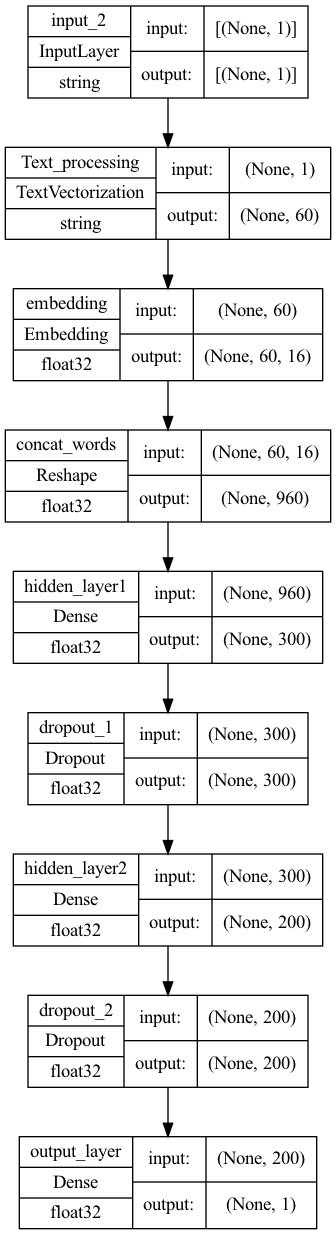

In [170]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [83]:
%%time
text_col, target_col = 'description', 'points'

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [57]:

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)


In [ ]:

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

In [173]:
test_data['dnn_prediction'] = model.predict(test_data[text_col])

 62/750 [=>............................] - ETA: 1s

2022-06-30 20:34:54.687830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 2s 2ms/step


In [175]:
dnn_concat = calc_prediction_quality(test_data, 'dnn_prediction', target_col)
dnn_concat

MSE    4.953888
MAE    1.796550
R2     0.486376
dtype: float64

### Using external embedding (description feature only)

Follow https://keras.io/examples/nlp/pretrained_word_embeddings/

You can either average the description words embeddings, concatinate them or do both and compare. 

In [177]:
all_compared.to_csv('all_models_summary.csv', index=True)

In [58]:

import numpy as np
# Use the glove file to create a mapping of words to numeric vectors

import os

path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "personal/ml-course/glove.6B/glove.6B.300d.txt"
)



embeddings_index = {}
with open(path_to_glove_file, encoding='utf8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


Found 400000 word vectors.


In [59]:
vocab = vectorize_layer.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))

In [60]:
num_tokens = len(vocab) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 19458 words (12542 misses)


In [61]:
# create embedding layer using the embedding matrix
from tensorflow import keras
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [62]:
from numpy.random import random
import numpy
# create model

hidden_layers_neurons = [128, 128]
droput = 0.2

activation_function = 'tanh'

def get_hidden_layer(neurons, drop, name, reg=None, activation='tanh') -> list[keras.layers.Layer]:
    return [
        Dense(
            neurons,
            activation=activation,
            name=f'hidden_layer_{name}',
            kernel_regularizer=reg,
        ),
        Dropout(drop)
    ]

hidden_layers = list(
    numpy.concatenate(
        [get_hidden_layer(neurons, droput, random()) for neurons in hidden_layers_neurons]
    ).flat
)


model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    embedding_layer,
    GlobalAveragePooling1D(),
    *hidden_layers,
    Dense(1, name = 'output_layer')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 300)           9600600   
                                                                 
 global_average_pooling1d_1   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 hidden_layer_0.662030659743  (None, 128)              38528     
 1539 (Dense)                                                    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                      

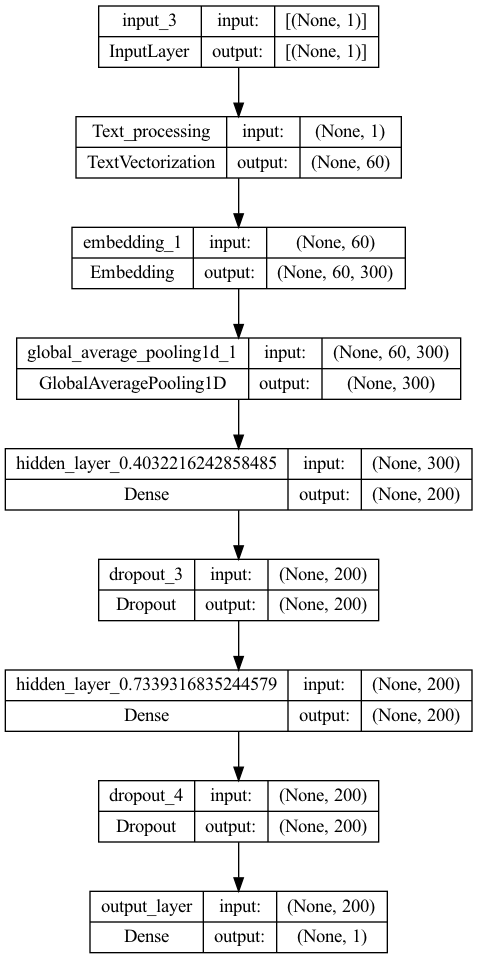

In [184]:
tf.keras.utils.plot_model(model, show_dtype=False, show_shapes=True, show_layer_names=True)

In [65]:
from tensorflow.keras.optimizers import Adam, SGD, Nadam, Adadelta

opt = Adam(learning_rate=0.001)

In [66]:

model.compile(
    loss='mse', optimizer=opt, metrics=['mean_squared_error','mean_absolute_error'])

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    restore_best_weights=True
)

In [67]:

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=35,
    batch_size=30,
    verbose=1,
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))


Epoch 1/35
   1/3466 [..............................] - ETA: 19:49 - loss: 7722.9863 - mean_squared_error: 7722.9858 - mean_absolute_error: 87.8194

2022-06-30 23:32:49.681355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3466/3466 [==============================] - ETA: 0s - loss: 380.8390 - mean_squared_error: 380.8390 - mean_absolute_error: 10.7631

2022-06-30 23:33:13.795804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3466/3466 [==============================] - 29s 8ms/step - loss: 380.8390 - mean_squared_error: 380.8390 - mean_absolute_error: 10.7631 - val_loss: 8.1913 - val_mean_squared_error: 8.1913 - val_mean_absolute_error: 2.2783
Epoch 2/35
3466/3466 [==============================] - 28s 8ms/step - loss: 5.2697 - mean_squared_error: 5.2697 - mean_absolute_error: 1.8074 - val_loss: 4.9241 - val_mean_squared_error: 4.9241 - val_mean_absolute_error: 1.7563
Epoch 3/35
3466/3466 [==============================] - 27s 8ms/step - loss: 4.2761 - mean_squared_error: 4.2761 - mean_absolute_error: 1.6431 - val_loss: 4.9316 - val_mean_squared_error: 4.9316 - val_mean_absolute_error: 1.7583
Epoch 4/35
3466/3466 [==============================] - 29s 8ms/step - loss: 4.1578 - mean_squared_error: 4.1578 - mean_absolute_error: 1.6200 - val_loss: 4.1658 - val_mean_squared_error: 4.1658 - val_mean_absolute_error: 1.6132
Epoch 5/35
3466/3466 [==============================] - 28s 8ms/step - loss: 4.0716 - mean

In [70]:
test_data['ext_embedding'] = model.predict(test_data[text_col])
ext_emb = calc_prediction_quality(test_data, 'ext_embedding', target_col)


813/813 [==============================] - 2s 2ms/step


MSE    4.165793
MAE    1.613198
R2     0.542268
dtype: float64

In [78]:
import matplotlib.pyplot as plt
def create_plot(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric][2:])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'validation ' + metric][2:])
    plt.show()

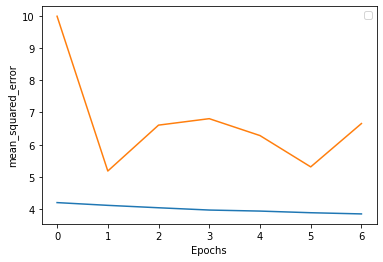

In [190]:

create_plot(history, "mean_squared_error")


 we see that there's over fitting, we'll try with regularization

In [191]:
stats = calc_prediction_quality(test_data, 'ext_embedding', target_col)
all_compared = all_compared.append(stats.to_frame(name='ext_embedding text only concat').transpose())
all_compared

/var/folders/37/gt5sm58d5s37rhym90b7k6f00000gn/T/ipykernel_31603/1872017763.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,MSE,MAE,R2
baseline_1,9.645944,2.548396,-0.000102
baseline_2,9.157956,2.476033,0.050493
baseline_3,8.598005,2.380009,0.108550
regression_by_xgb,6.344070,1.911618,0.342240
bow_ridge_gt_5,3.112649,1.385728,0.677277
bow_ridge_gt_4,3.107394,1.384678,0.677822
bow_ridge_gt_3,3.105675,1.383974,0.678000
bow_ridge_gt_2,3.103572,1.383460,0.678218
bow_ridge_gt_1,3.098569,1.382541,0.678737
all_features_ridge,3.723752,1.517671,0.613917


In [36]:
from tensorflow.keras import regularizers


hidden_layers = list(
    numpy.concatenate(
        [get_hidden_layer(neurons, droput, random(), regularizers.l2(0.001)) for neurons in [128]]
    ).flat
)


model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    embedding_layer,
    GlobalAveragePooling1D(),
    *hidden_layers,
    Dense(1, name = 'output_layer')
])

model.compile(
    loss='mse', optimizer=opt, metrics=['mean_squared_error','mean_absolute_error'])

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=35,
    batch_size=30,
    verbose=1,
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

NameError: name 'get_hidden_layer' is not defined

In [64]:
all_compared = pd.read_csv('all_models_summary.csv')
all_compared

,Unnamed: 0,MSE,MAE,R2
0,baseline_1,9.645944,2.548396,-0.000102
1,baseline_2,9.157956,2.476033,0.050493
2,baseline_3,8.598005,2.380009,0.108550
3,regression_by_xgb,6.344070,1.911618,0.342240
4,bow_ridge_gt_5,3.112649,1.385728,0.677277
5,bow_ridge_gt_4,3.107394,1.384678,0.677822
6,bow_ridge_gt_3,3.105675,1.383974,0.678000
7,bow_ridge_gt_2,3.103572,1.383460,0.678218
8,bow_ridge_gt_1,3.098569,1.382541,0.678737
9,all_features_ridge,3.723752,1.517671,0.613917


## LSTM

In [ ]:
dill.dump_session(dump_file_name)

See example here: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

In [73]:
from keras.layers import LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adamax, Nadam

hidden_layers = list(
    numpy.concatenate(
        [get_hidden_layer(
            neurons,
            droput,
            random(),
            regularizers.l2(0.001),
            activation='relu'
        ) for neurons in [64]]
    ).flat
)


model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size+1, embedding_dim, input_length= sequence_length, name="embedding", mask_zero=True),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu', name='hidden_layer'),
    Dense(1, name = 'output_layer')
])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 300)           9600300   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              186880    
 l)                                                              
                                                                 
 hidden_layer (Dense)        (None, 64)                8256      
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 9,795,501
Trainable params: 9,795,501
No

In [74]:

model.compile(
    loss='mse', optimizer=opt, metrics=['mean_squared_error','mean_absolute_error'])

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=35,
    batch_size=30,
    verbose=1,
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))


Epoch 1/35


2022-06-30 23:40:56.644172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-30 23:40:57.162007: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_LEGACY_VARIANT
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_40/output/_24'
2022-06-30 23:40:57.165517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-30 23:40:57.284029: I tens

3466/3466 [==============================] - ETA: 0s - loss: 24.7246 - mean_squared_error: 24.7246 - mean_absolute_error: 2.0910

2022-06-30 23:45:08.830995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-30 23:45:09.140716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-30 23:45:09.193645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3466/3466 [==============================] - 279s 79ms/step - loss: 24.7246 - mean_squared_error: 24.7246 - mean_absolute_error: 2.0910 - val_loss: 3.1431 - val_mean_squared_error: 3.1431 - val_mean_absolute_error: 1.3911
Epoch 2/35
3466/3466 [==============================] - 261s 75ms/step - loss: 2.6074 - mean_squared_error: 2.6074 - mean_absolute_error: 1.2627 - val_loss: 2.7835 - val_mean_squared_error: 2.7835 - val_mean_absolute_error: 1.3081
Epoch 3/35
3466/3466 [==============================] - 269s 78ms/step - loss: 2.2366 - mean_squared_error: 2.2366 - mean_absolute_error: 1.1666 - val_loss: 2.5679 - val_mean_squared_error: 2.5679 - val_mean_absolute_error: 1.2476
Epoch 4/35
3466/3466 [==============================] - 281s 81ms/step - loss: 1.9628 - mean_squared_error: 1.9628 - mean_absolute_error: 1.0874 - val_loss: 2.5899 - val_mean_squared_error: 2.5899 - val_mean_absolute_error: 1.2499
Epoch 5/35
3466/3466 [==============================] - 275s 79ms/step - loss: 1.7729

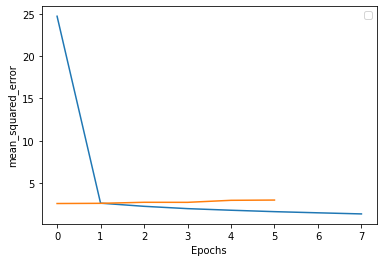

In [79]:

create_plot(history, "mean_squared_error")

In [85]:
test_data['lstm'] = model.predict(test_data[text_col])


2022-07-01 00:35:39.600928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-01 00:35:39.950381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-01 00:35:40.026510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


813/813 [==============================] - 27s 31ms/step


In [ ]:

stats = calc_prediction_quality(test_data, 'lstm', target_col)
all_compared = all_compared.append(stats.to_frame(name='lstm').transpose())
all_compared

In [ ]:
all_compared.to_csv('all_models_summary.csv', index=True)

In [88]:
all_compared = pd.read_csv('all_models_summary.csv', index_col=0)
all_compared

,MSE,MAE,R2
Unnamed: 0,,,
baseline_1,9.645944,2.548396,-0.000102
baseline_2,9.157956,2.476033,0.050493
baseline_3,8.598005,2.380009,0.108550
regression_by_xgb,6.344070,1.911618,0.342240
bow_ridge_gt_5,3.112649,1.385728,0.677277
bow_ridge_gt_4,3.107394,1.384678,0.677822
bow_ridge_gt_3,3.105675,1.383974,0.678000
bow_ridge_gt_2,3.103572,1.383460,0.678218
bow_ridge_gt_1,3.098569,1.382541,0.678737


### Bonus (Not mandatory) Use all features using Keras functional API

See here: https://keras.io/guides/functional_api/

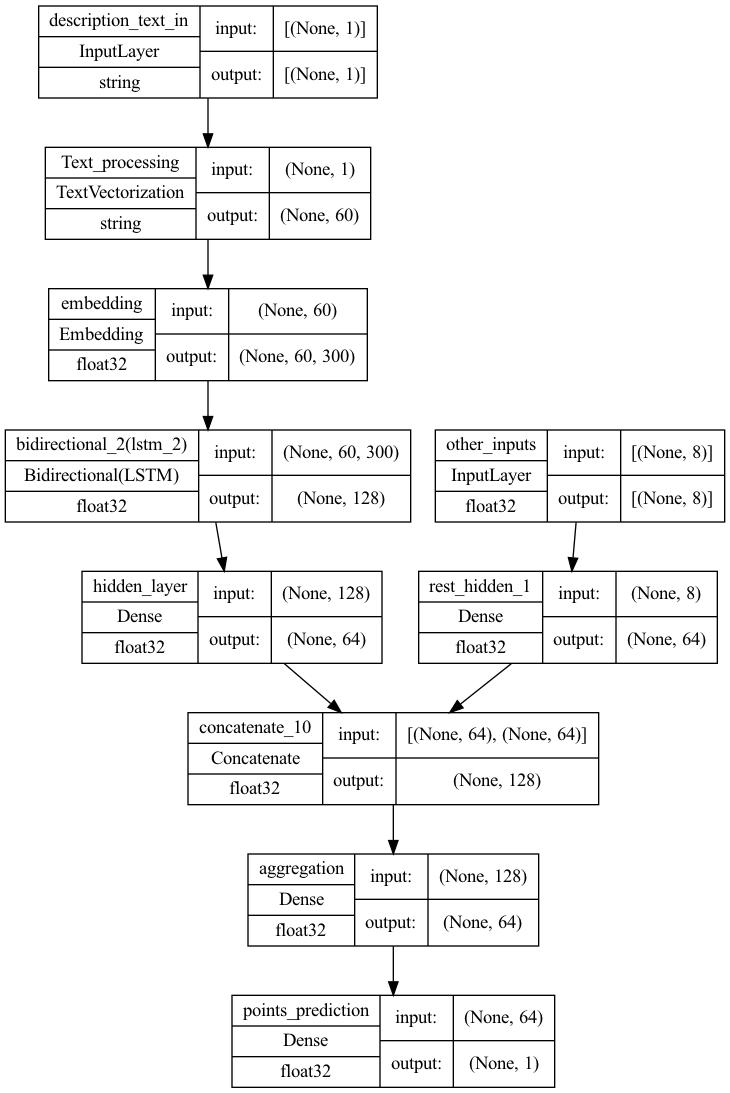

In [101]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

description_in = keras.Input(shape=(1,), dtype=tf.string, name='description_text_in')
description_tokenization = vectorize_layer(description_in)
description_embedding = layers.Embedding(vocab_size+1, embedding_dim, input_length= sequence_length, name="embedding", mask_zero=True)(description_tokenization)
description_lstm = layers.Bidirectional(layers.LSTM(64))(description_embedding)
description_inner_1 = Dense(64, activation='relu', name='hidden_layer')(description_lstm)

rest_params_input = keras.Input(shape=(8,), name="other_inputs")
rest_params_inner1 = layers.Dense(64, name="rest_hidden_1")(rest_params_input)


concatenation = layers.concatenate([description_inner_1, rest_params_inner1])

aggregate_hidden_1 = layers.Dense(64,name='aggregation')(concatenation)

prediction_layer = layers.Dense(1, name="points_prediction")(aggregate_hidden_1)


model = keras.Model(
    inputs=[description_in, rest_params_input],
    outputs=[prediction_layer],
)

tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [104]:
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='mse', optimizer=optimizer, metrics=['mean_squared_error','mean_absolute_error'])

In [133]:
history = model.fit(
    x=[train_data[text_col], encoded_train],
    y=train_data[target_col],
    epochs=35,
    batch_size=30,
    verbose=1,
    callbacks=[early_stopping_monitor],
    validation_data = ([test_data[text_col], encoded_test], test_data[target_col]))

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'pandas.core.series.Series'>", "<class 'scipy.sparse.coo.coo_matrix'>"}), <class 'pandas.core.series.Series'>